In [62]:
import pandas as pd
from pandas import Series, DataFrame
import os  # dealing with directories
import cv2  # working with, mainly resizing, images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from PIL import Image as im
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def dfbuilder(files):
    final=pd.DataFrame(columns=['Time_x', 'Experiment_x', ' Hand Type_x', ' # hands_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',' Pinch Strength_x', 
       'Time_y', 'Experiment_y',
       ' Hand Type_y', ' # hands_y', ' Position X_y', ' Position Y_y',
       ' Position Z_y', ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y',
       ' Pitch_y', ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y'])
    for file in files:
        temp=pd.read_csv(file)
        # ignoring the first 7 seconds.
        temp=temp.iloc[700:]
        temp[" Hand Type"]=Series([1 if i=="right" else 2 for i in temp[" Hand Type"]])
        # if the file contain the alone (left hand) string the function tries to merge it with the right hand that suits.
        if str.__contains__(file,"Alone"):  
            temp.insert(loc=1, column='Experiment', value="1")
            temp=temp.drop(' Frame ID',axis=1)
            Handright=pd.read_csv('/Users/idobar/Documents/GitHub/test/extraFiles/HandRight.csv')
            Handright[" Hand Type"]=Series([1 if i=="right" else 2 for i in Handright[" Hand Type"]])
            Handright.insert(loc=1, column='Experiment', value="1")
            Handright = Handright.iloc[:len(temp)-1]
            Handright = Handright.reset_index(drop=True)
            Handright=Handright.drop(' Frame ID',axis=1)
            temp = temp.reset_index(drop=True)
            temp = pd.merge(temp, Handright, left_index=True, right_index=True)# merging alone and right.
        # if the string is not containing the aline string it checks if the string contain Sync or Spontan.  
        # if the string contain one of the two it gives the Experiment the matching value.
        else:
            if str.__contains__(file,"Sync"):
                temp.insert(loc=1, column='Experiment', value="2")
            if str.__contains__(file,"Spontan"):
                temp.insert(loc=1, column='Experiment', value="3") 
            dfright=temp[temp[" Hand Type"]==1]
            dfleft=temp[temp[" Hand Type"]==2]
            dfright.set_index(' Frame ID',inplace=True)
            dfleft.set_index(' Frame ID',inplace=True)
            temp=pd.merge(dfleft, dfright, how='left',on=' Frame ID') 
        final=pd.concat([final,temp])
        
    final=final.drop(["Experiment_y"],axis=1) 
    final=final.dropna()
    final[final.index%20==2]
    final.sort_index(inplace=True)
    return final

In [3]:
import glob
#The glob module finds all the pathnames matching a specified pattern.
test= dfbuilder(glob.glob('/Users/idobar/Documents/GitHub/test/extraFiles/Validation/**/*.csv', recursive=True))
train= dfbuilder(glob.glob('/Users/idobar/Documents/GitHub/test/extraFiles/Training/**/*.csv', recursive=True))
train.head()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,624.5214,1,2.0,1,-129.871500,238.8927,15.15365,-260.49200,268.55510,57.91444,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,507.6639,1,2.0,1,-54.173900,404.6508,102.53100,-46.37540,-141.27270,-30.21356,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,591.7358,1,1.0,1,-19.865460,181.0220,102.09490,-36.13705,-89.59768,-43.82156,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,712.9770,1,2.0,1,-81.244640,198.4695,59.23386,-171.53010,226.72650,431.11130,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,300.3558,1,2.0,1,0.483595,263.7752,48.87287,-73.14426,247.44700,-70.95473,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0


In [41]:
train.tail()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
147031,496.3350,2,2.0,2,-88.72741,133.6054,80.84770,19.672070,109.4840,-148.49250,...,-0.450688,148.5828,145.7623,81.60815,361.1390,39.55280,166.3942,0.0,0.181054,0.0
147033,496.3516,2,2.0,2,-88.94987,136.6372,79.13829,5.798031,201.9729,-96.20036,...,-0.448909,148.3703,145.3627,81.36929,361.1625,39.38863,165.8574,0.0,0.178520,0.0
147035,496.3684,2,2.0,2,-89.34464,140.2418,77.55276,-62.854220,271.6032,-69.40147,...,-0.447422,148.3899,145.1390,81.37563,362.0198,39.16170,163.7183,0.0,0.176777,0.0
147037,496.3849,2,2.0,2,-90.04370,144.5540,76.09414,-25.792180,229.5740,-96.95150,...,-0.447172,148.6771,145.2287,81.51376,363.2723,39.67188,161.8624,0.0,0.174231,0.0
147039,496.4013,2,2.0,2,-91.27801,150.2716,75.28820,-82.378340,386.3372,-18.65937,...,-0.448133,149.3459,145.9781,81.90491,364.6587,39.78413,159.4454,0.0,0.173893,0.0


In [56]:
train.groupby('Experiment_x').count()

,Time_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
Experiment_x,,,,,,,,,,,,,,,,,,,,,
1,26222,26222,26222,26222,26222,26222,26222,26222,26222,26222,...,26222,26222,26222,26222,26222,26222,26222,26222,26222,26222
2,30991,30991,30991,30991,30991,30991,30991,30991,30991,30991,...,30991,30991,30991,30991,30991,30991,30991,30991,30991,30991
3,31156,31156,31156,31156,31156,31156,31156,31156,31156,31156,...,31156,31156,31156,31156,31156,31156,31156,31156,31156,31156


In [58]:
train['Experiment_x'].value_counts()

3    31156
2    30991
1    26222
Name: Experiment_x, dtype: int64

## Visualization

In [29]:
train.isnull().sum().sum()

0

In [30]:
test.isnull().sum().sum()

0

In [6]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (88369, 43)
Test shape: (25233, 43)


<AxesSubplot:xlabel='Experiment_x', ylabel='count'>

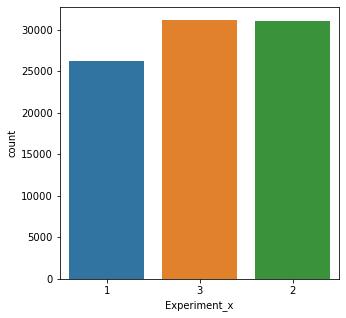

In [7]:
plt.figure(figsize = (5,5))
sns.countplot(x = "Experiment_x", data = train)

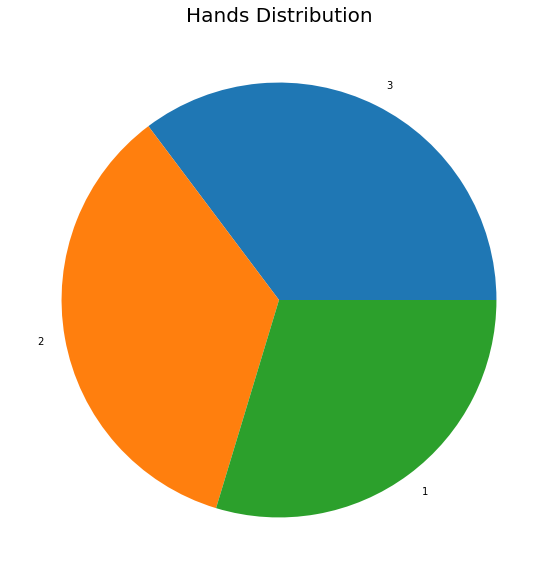

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize=(10, 10))
axes= train.Experiment_x.value_counts().plot(kind='pie')
axes.set_title("Hands Distribution", fontsize=20)
axes.set_xlabel("")
axes.set_ylabel("")

fig1 = plt.gcf()
plt.show()
plt.draw()

Text(0, 0.5, 'Y pos left')

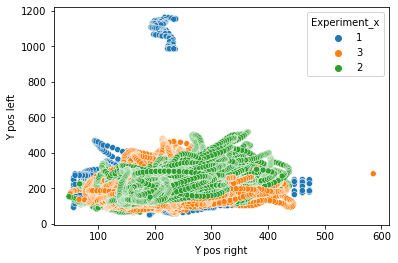

In [8]:
sns.scatterplot(x=" Position Y_y", y=" Position Y_x", hue="Experiment_x", data=train)
plt.xlabel('Y pos right')
plt.ylabel('Y pos left')

In [9]:
data_Alone = train[train['Experiment_x']=='1']
data_NotAlone = train[train['Experiment_x']!='1']

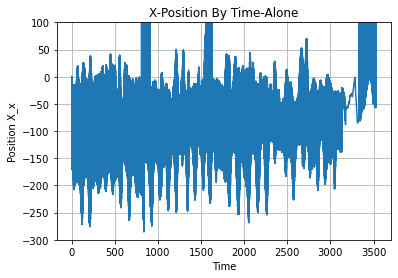

In [10]:
fig, ax = plt.subplots()
ax.plot(data_Alone[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'Position X_x', title = 'X-Position By Time-Alone')
ax.grid()
plt.ylim(-300,100)
plt.show()

In [11]:
data_Spontan = train[train['Experiment_x']=='2']
data_NotSpontan = train[train['Experiment_x']!='2']

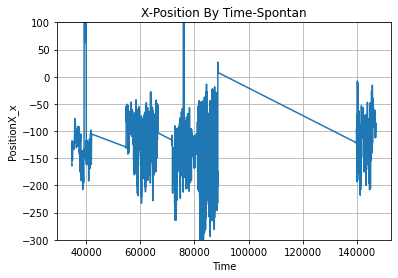

In [12]:
fig, ax = plt.subplots()
ax.plot(data_Spontan[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'PositionX_x', title = 'X-Position By Time-Spontan')
ax.grid()
plt.ylim(-300,100)
plt.show()

In [13]:
data_Sync = train[train['Experiment_x']=='3']
data_NotSync = train[train['Experiment_x']!='3']

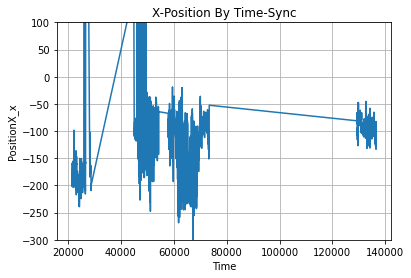

In [14]:
fig, ax = plt.subplots()
ax.plot(data_Sync[' Position X_x'])
ax.set(xlabel = 'Time', ylabel = 'PositionX_x', title = 'X-Position By Time-Sync')
ax.grid()
plt.ylim(-300,100)
plt.show()

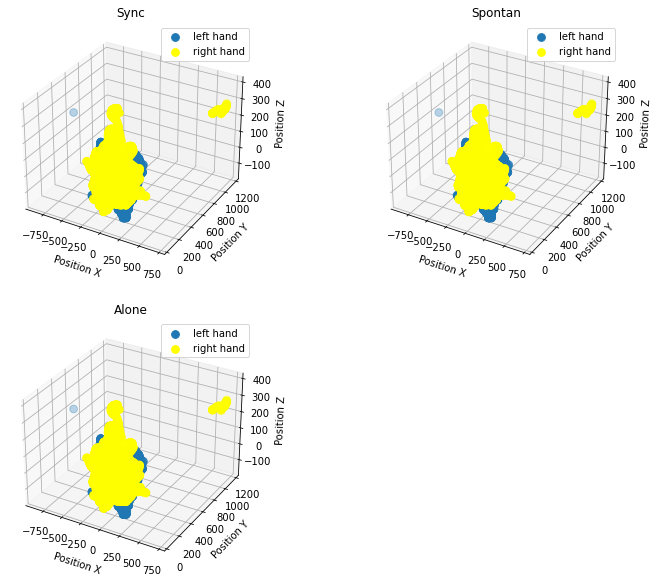

In [15]:
df = train.drop('Experiment_x',axis=1)
fig = plt.figure(figsize=(12, 10))
Type = ['Sync', 'Spontan','Alone']
count = 1
for t in Type:
    ax = fig.add_subplot(2, 2, count, projection='3d')
    count+=1
    ax.title.set_text(t)
    plt.gca().legend(('left','right'))
    ax.scatter(df[' Position X_y'], df[' Position Y_y'], df[' Position Z_y'],s=60, label='left hand')
    ax.scatter(df[' Position X_x'], df[' Position Y_x'], df[' Position Z_x' ], color='yellow',s=60, label='right hand')
    plt.legend()
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    ax.set_zlabel('Position Z')

## Preprocessing 

In [44]:
# Droping the Experiment_x column in order to get the target of the data.
x=train[['Time_x', ' Hand Type_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',
       ' Pinch Strength_x', 'Time_y', ' Hand Type_y',
       ' Position X_y', ' Position Y_y', ' Position Z_y',
       ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y', ' Pitch_y',
       ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y']]
y=train['Experiment_x']
X_test_test=test[['Time_x', ' Hand Type_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',
       ' Pinch Strength_x', 'Time_y', ' Hand Type_y',
       ' Position X_y', ' Position Y_y', ' Position Z_y',
       ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y', ' Pitch_y',
       ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y']]
y_test_test=test['Experiment_x']

In [45]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(x,y, train_size=0.7, random_state=0)

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [47]:
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)

(61858, 40)
(61858,)
(26511, 40)
(26511,)


(None, None)

In [48]:
print("The train set as:",len(X_train),"Samples")
print("The test set as:",len(X_val),"Samples")

The train set as: 61858 Samples
The test set as: 26511 Samples


## Models

### KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 30))
acc = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    neigh_pred = knn.predict(X_val)
    acc.append(metrics.accuracy_score(y_val, neigh_pred))
acc

[0.9993964769341028,
 0.9990569952095356,
 0.999283316359247,
 0.9990569952095356,
 0.99894383463468,
 0.9983780317604013,
 0.9981894308023085,
 0.9977745086945041,
 0.9977367885028856,
 0.9969823846705141,
 0.996906944287277,
 0.996378861604617,
 0.9963034212213798,
 0.9952095356644411,
 0.9950963750895855,
 0.9945305722153068,
 0.9944174116404512,
 0.9937384481913168,
 0.9937007279996982,
 0.9929086039757082,
 0.9927954434008525,
 0.9922296405265739,
 0.9919278789936253,
 0.9916261174606767,
 0.9911734751612539,
 0.9906076722869752,
 0.9904190713288824,
 0.9901550299875523,
 0.9898532684546038]

In [49]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
clf_pred=clf.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7786
           2       0.90      0.88      0.89      9314
           3       0.89      0.90      0.89      9411

    accuracy                           0.92     26511
   macro avg       0.93      0.93      0.93     26511
weighted avg       0.92      0.92      0.92     26511

Accuracy: 0.9233525706310588


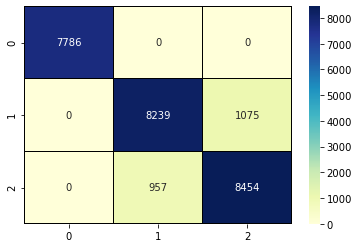

In [50]:
confMatrix = confusion_matrix(y_val, clf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, clf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,clf_pred)
print("Accuracy:",result2)

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)
rf_pred=rf.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7786
           2       1.00      1.00      1.00      9314
           3       1.00      1.00      1.00      9411

    accuracy                           1.00     26511
   macro avg       1.00      1.00      1.00     26511
weighted avg       1.00      1.00      1.00     26511

Accuracy: 0.9999622798083814


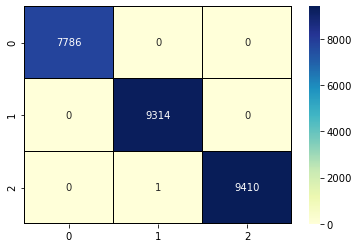

In [53]:
confMatrix = confusion_matrix(y_val, rf_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, rf_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,rf_pred)
print("Accuracy:",result2)

In [60]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_val)
gnb_score = gnb.score(X_val,y_val)*100

In [63]:
f=f1_score(y_val, gnb_pred,average='weighted')
print('f-score', f)

f-score 0.5839503406143383


Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.28      0.44      7786
           2       0.68      0.88      0.77      9314
           3       0.47      0.60      0.53      9411

    accuracy                           0.61     26511
   macro avg       0.71      0.59      0.58     26511
weighted avg       0.70      0.61      0.58     26511

Accuracy: 0.6063898004601863


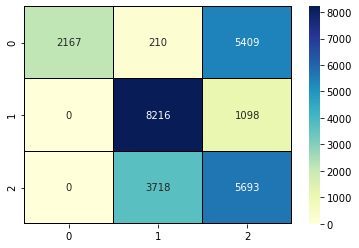

In [64]:
confMatrix = confusion_matrix(y_val, gnb_pred)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, gnb_pred,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,gnb_pred)
print("Accuracy:",result2)

In [65]:
import xgboost
xgb=xgboost.XGBClassifier(n_estimators=150,eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xgb_p=xgb.predict(X_val)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7786
           2       1.00      1.00      1.00      9314
           3       1.00      1.00      1.00      9411

    accuracy                           1.00     26511
   macro avg       1.00      1.00      1.00     26511
weighted avg       1.00      1.00      1.00     26511

Accuracy: 1.0


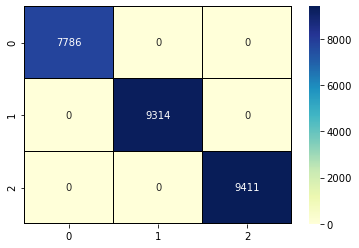

In [66]:
confMatrix = confusion_matrix(y_val, xgb_p)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, xgb_p,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,xgb_p)
print("Accuracy:",result2)

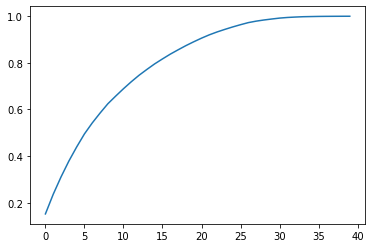

In [67]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X_train)
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

In [69]:
pca=PCA(n_components=0.9)
X_trainreduce=pca.fit_transform(X_train)
X_validreduce=pca.transform(X_val)

In [70]:
pca.n_components_

21

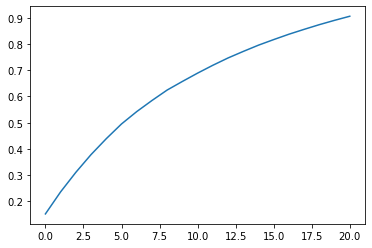

In [71]:
sum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(sum)

In [72]:
X_train_pca=pd.DataFrame(X_trainreduce)
X_valid_pca=pd.DataFrame(X_validreduce)

In [73]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train_pca,y_train)
clf_pred_pca=clf.predict(X_valid_pca)

Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      7786
           2       0.85      0.85      0.85      9314
           3       0.84      0.85      0.85      9411

    accuracy                           0.89     26511
   macro avg       0.89      0.89      0.89     26511
weighted avg       0.89      0.89      0.89     26511

Accuracy: 0.8877447097431255


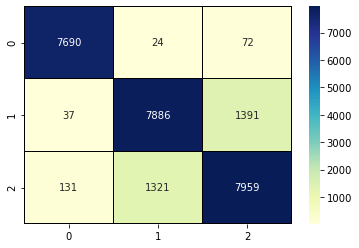

In [74]:
confMatrix = confusion_matrix(y_val, clf_pred_pca)
sns.heatmap(confMatrix, annot=True, fmt="d",linecolor='black',linewidths=.2,cmap="YlGnBu")
result1 = classification_report(y_val, clf_pred_pca,zero_division=1)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,clf_pred_pca)
print("Accuracy:",result2)